In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Tengai.dataset import AirQuality
from Tengai.preprocessing import clustering_data,detect_outlier_zscore
from Tengai.visual_series import (lineplot_features,lineplot_resample_feature,
                                  average_generating_barplot,visualize_adfuller_results)
import statsmodels.api as sm
from Tengai.model import grangers_causation_matrix

## Load Data

In [2]:
data = AirQuality(-8.2325,114.3576)
data

,time,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
0,2023-01-01 00:00:00,38.5,26.7,716.0,9.6,47.0,0.36,0.0
1,2023-01-01 01:00:00,31.1,21.4,624.0,7.8,60.0,0.34,0.0
2,2023-01-01 02:00:00,26.3,17.9,492.0,5.2,79.0,0.31,0.0
3,2023-01-01 03:00:00,24.2,16.4,347.0,2.5,98.0,0.29,0.0
4,2023-01-01 04:00:00,23.1,15.7,295.0,1.5,102.0,0.32,0.0
...,...,...,...,...,...,...,...,...
7051,2023-10-21 19:00:00,30.7,21.0,779.0,9.8,24.0,0.34,0.0
7052,2023-10-21 20:00:00,30.3,20.8,746.0,8.6,21.0,0.35,0.0
7053,2023-10-21 21:00:00,30.2,20.8,686.0,7.4,24.0,0.36,0.0
7054,2023-10-21 22:00:00,30.5,21.1,569.0,5.9,37.0,0.36,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7056 entries, 0 to 7055
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time                   7056 non-null   datetime64[ns]
 1   pm10                   7056 non-null   float64       
 2   pm2_5                  7056 non-null   float64       
 3   carbon_monoxide        7056 non-null   float64       
 4   nitrogen_dioxide       7056 non-null   float64       
 5   ozone                  7056 non-null   float64       
 6   aerosol_optical_depth  7056 non-null   float64       
 7   dust                   7056 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 441.1 KB


# EDA

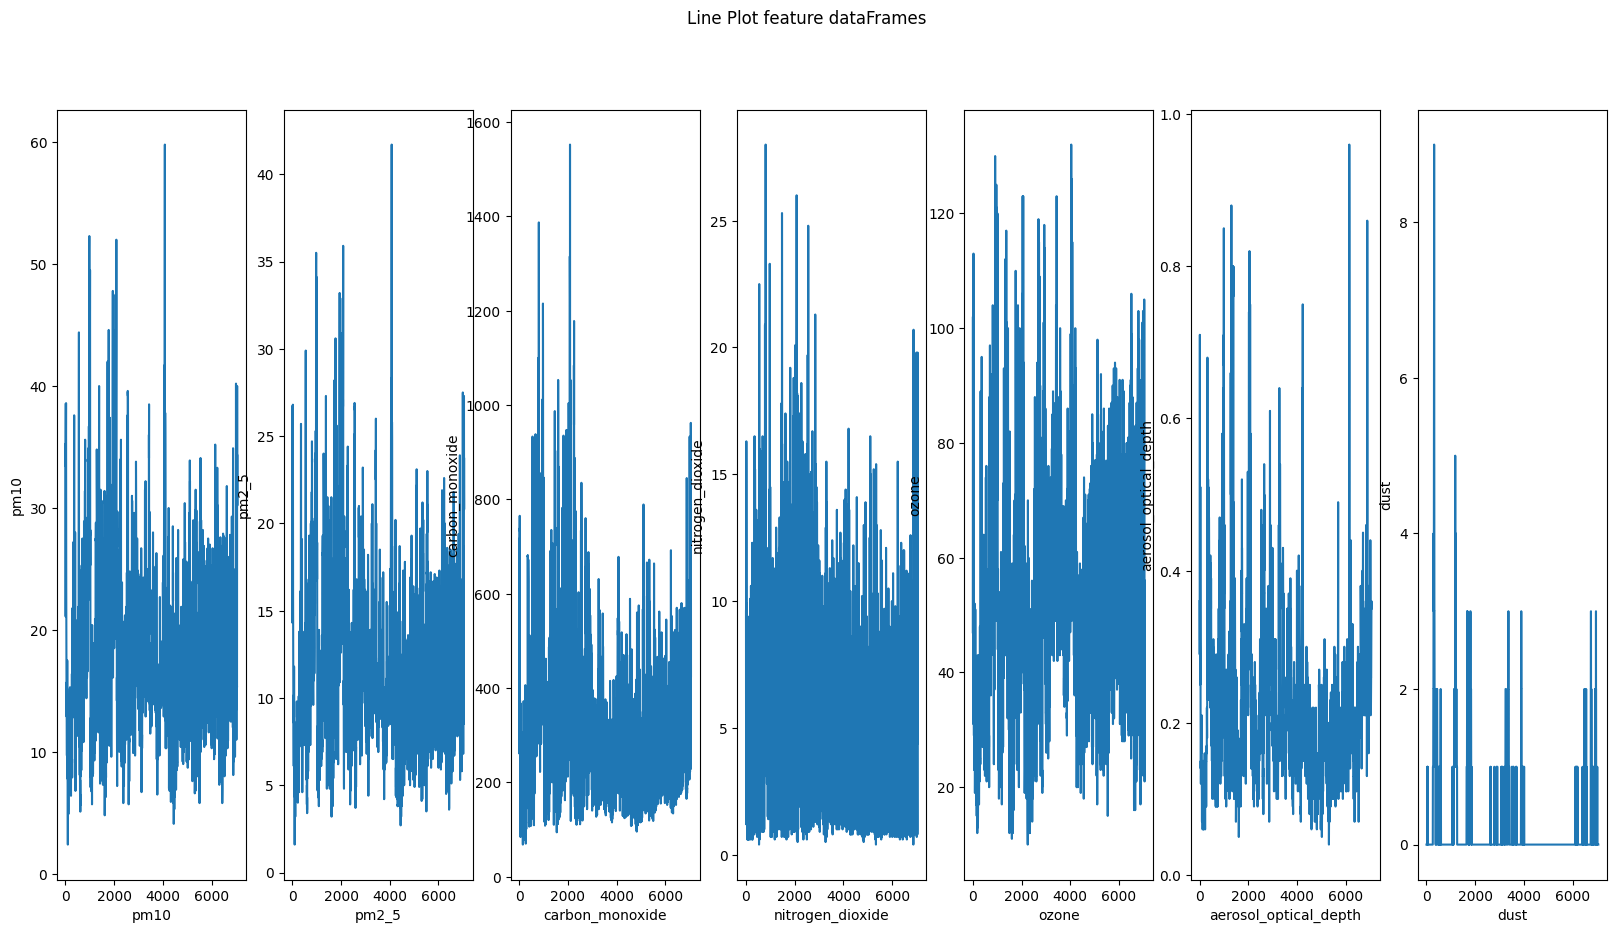

In [4]:
lineplot_features(data.iloc[:,1:],size=(20,10))

### Resample Line Plot

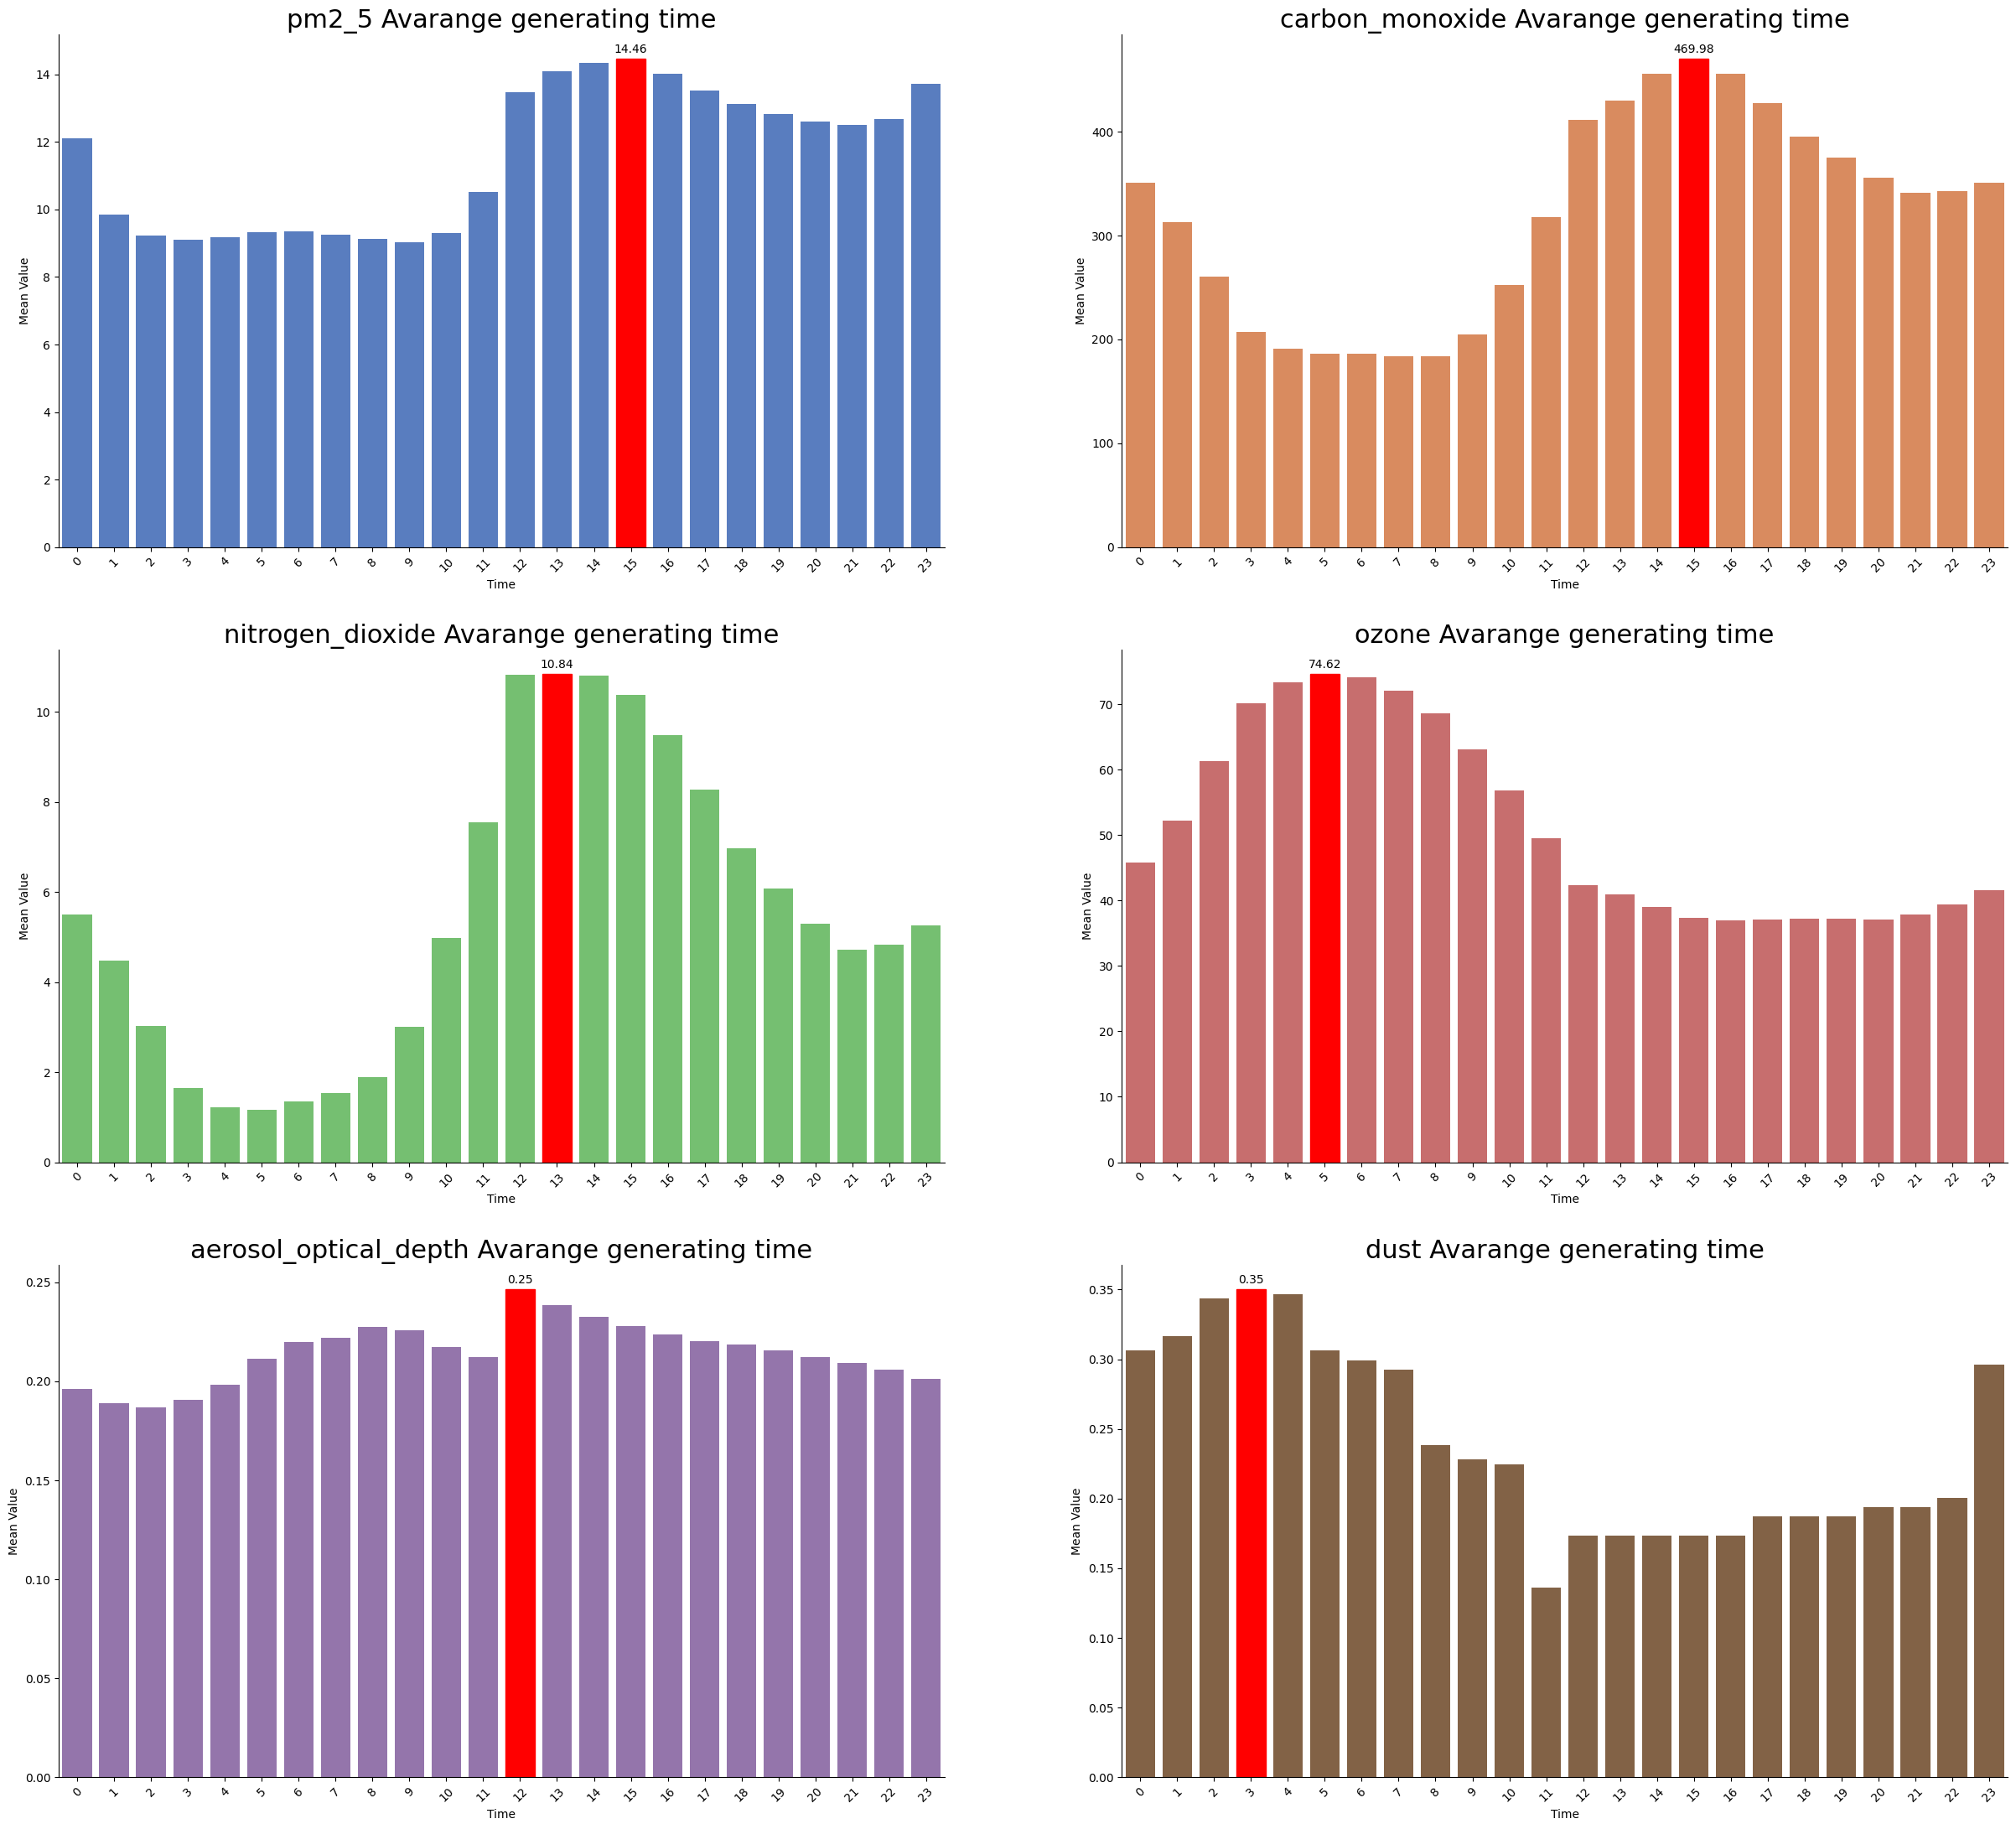

In [5]:
average_generating_barplot(data,on_feat="time")

### Linear Resample feature

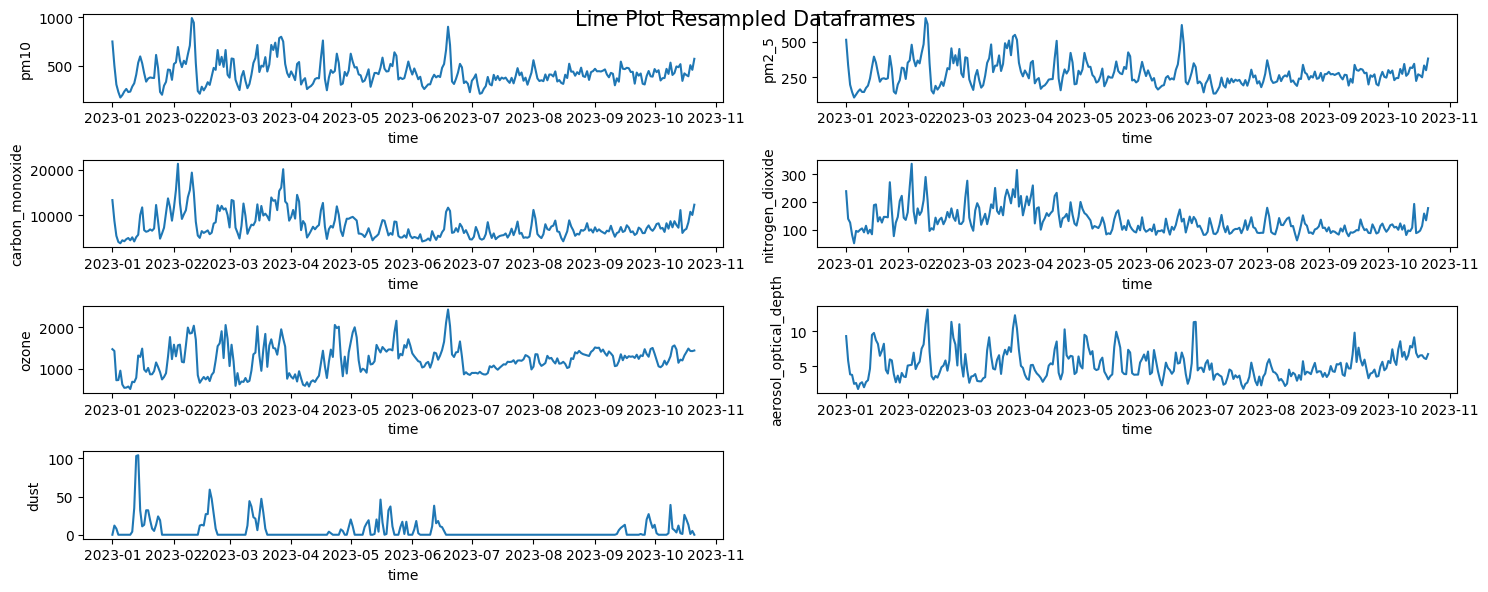

In [6]:
lineplot_resample_feature(data,"time","1D")

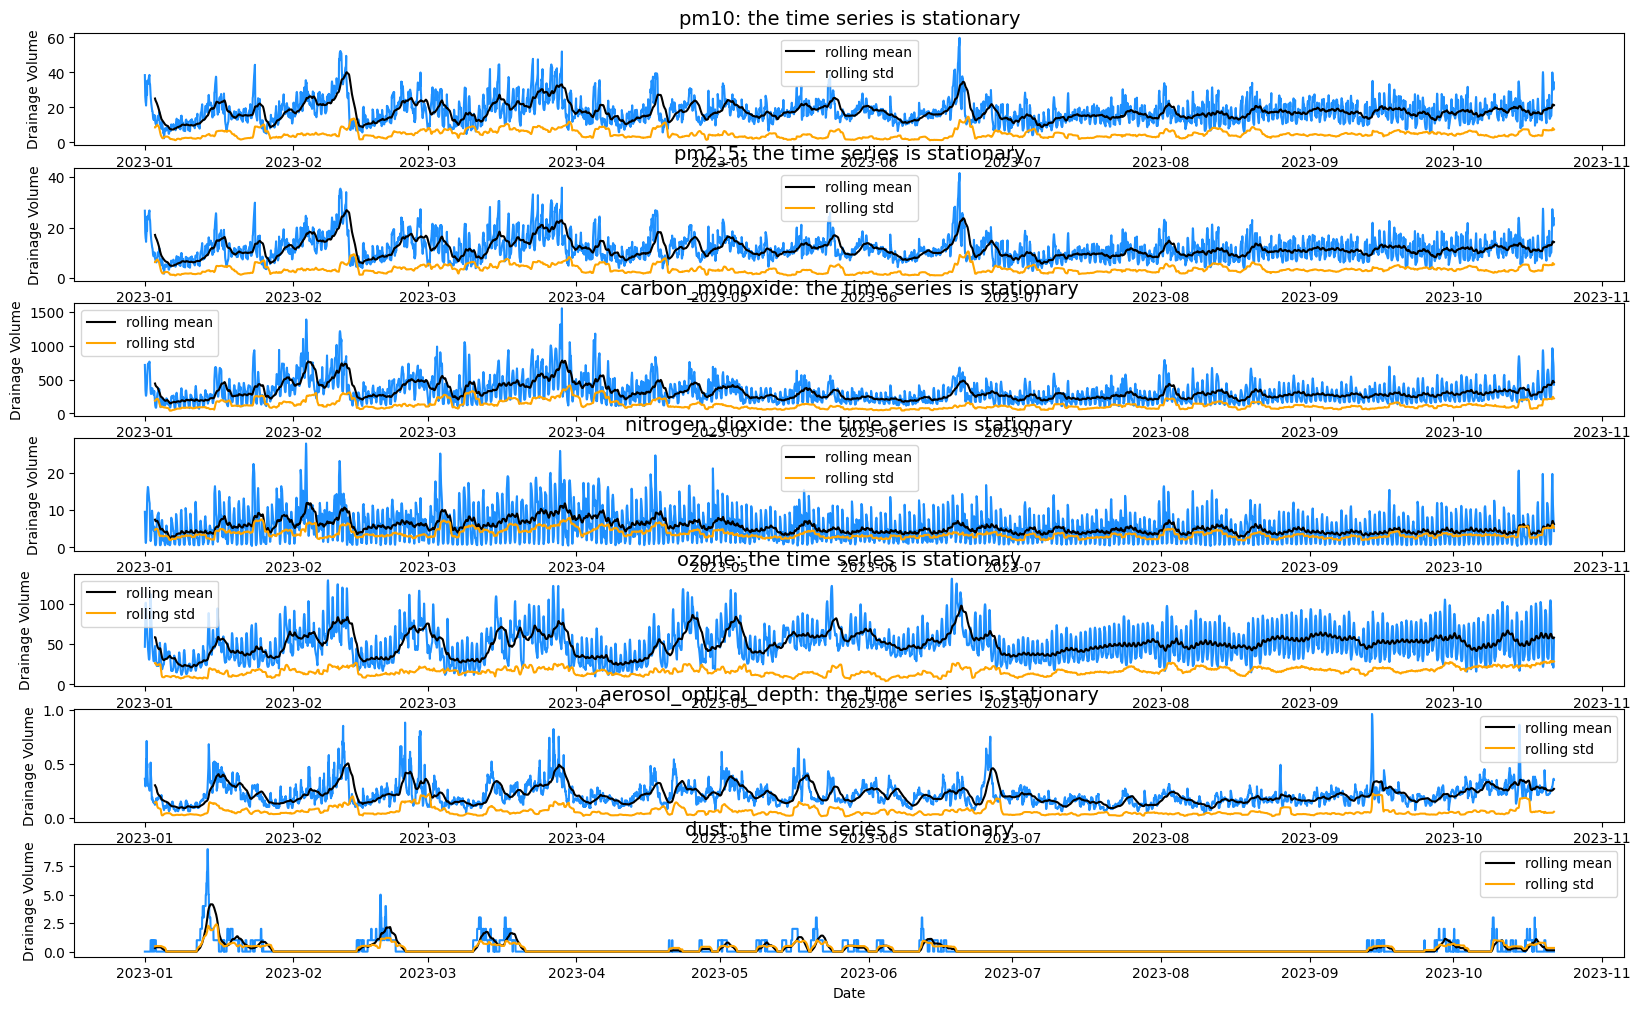

In [7]:
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import pandas as pd

def plot_rolling_statistics(df: pd.DataFrame, rolling_window=7):
    """
    Plot rolling statistics for a given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        rolling_window (int, optional): Rolling window size for mean and std calculations. Defaults to 7.

    Returns:
        None: This function displays the plot but doesn't return any value.
    """
    numerical_features = df.select_dtypes(include=np.number).columns
    f, ax = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(20, 12))
    
    for i, feat in enumerate(numerical_features):
        sns.lineplot(x=df['time'], y=df[feat], ax=ax[i], color='dodgerblue')
        sns.lineplot(x=df['time'], y=df[feat].rolling(rolling_window).mean(), ax=ax[i], color='black', label='rolling mean')
        sns.lineplot(x=df['time'], y=df[feat].rolling(rolling_window).std(), ax=ax[i], color='orange', label='rolling std')
        
        # Calculate ADF test results
        adf_result = adfuller(df[feat], autolag="AIC")
        if adf_result[1] <= 0.05:
            ax[i].set_title(f'{feat}: the time series is stationary', fontsize=14)
        else:
            ax[i].set_title(f'{feat}: the time series is non-stationary', fontsize=14)

        # Add labels and legend
        ax[i].set_xlabel('Date')
        ax[i].set_ylabel('Drainage Volume')
        ax[i].legend()

    # Show the plot
    plt.show()

# Example usage:
plot_rolling_statistics(data,52)

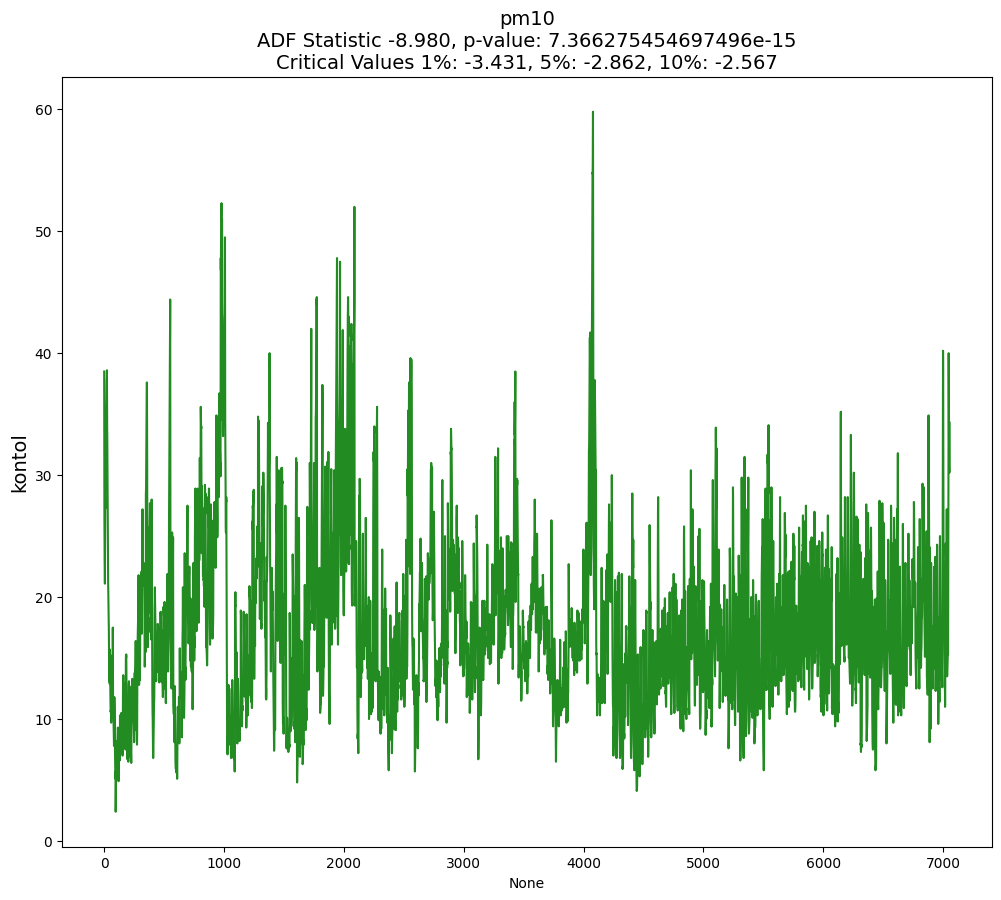

In [8]:
visualize_adfuller_results(data,"pm10","kontol")

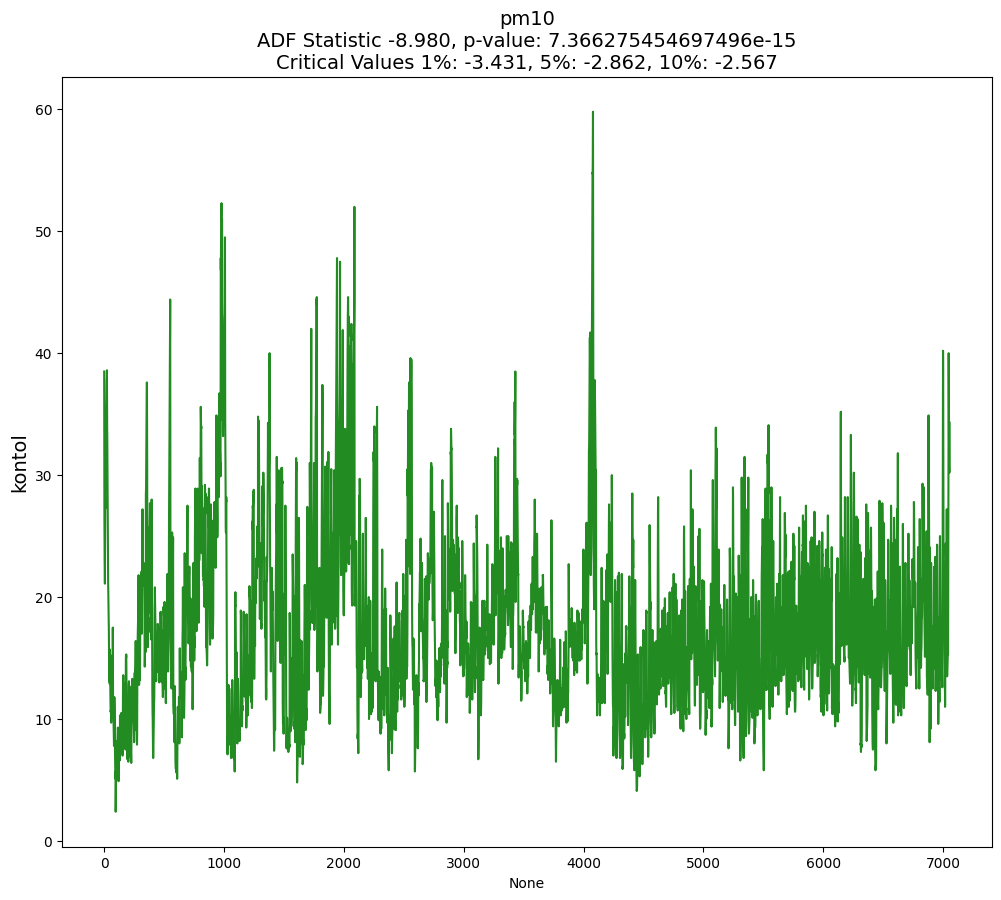

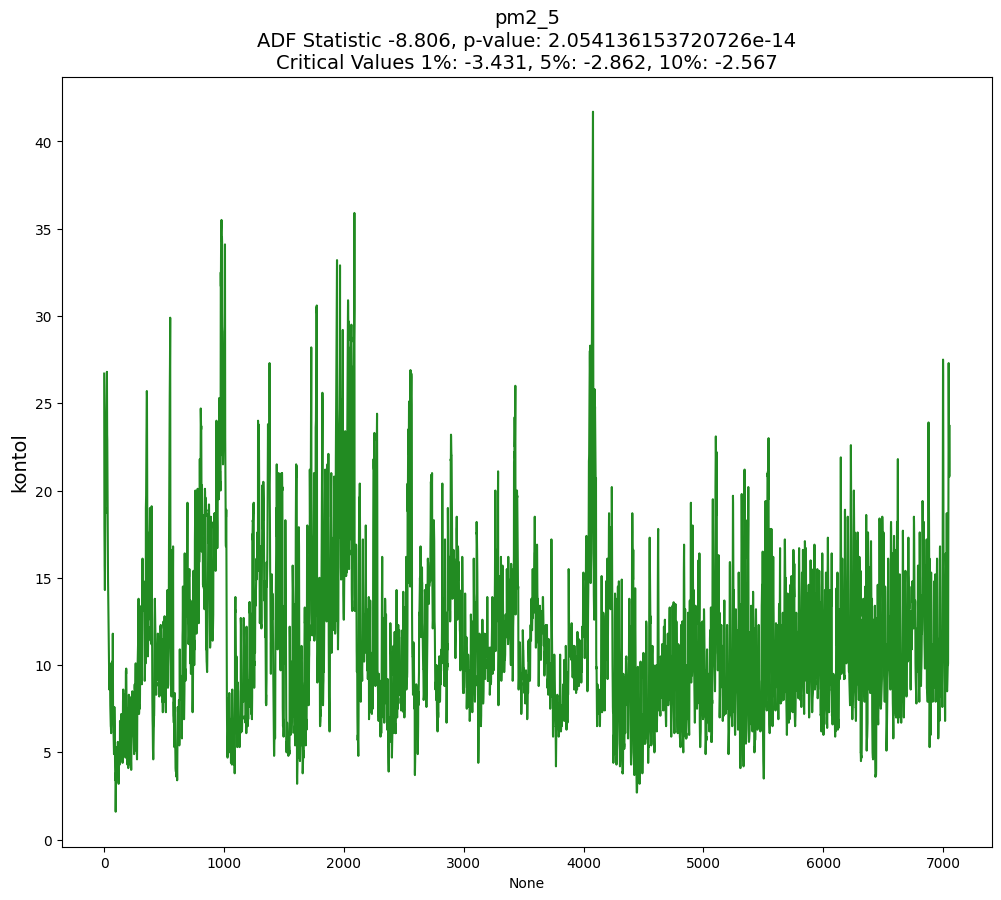

In [9]:
visualize_adfuller_results(data,["pm10","pm2_5"],"kontol")

## Data Preprocessing

#### - For Clustering Model

In [10]:
data_cluster = data.set_index("time").resample("D").mean()
data_cluster.reset_index(inplace=True)
# droping `time` feature
data_cluster.drop(["time","dust"],axis=1,inplace=True)
data_cluster.head()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth
0,31.179167,21.466667,554.750000,9.929167,61.458333,0.387083
1,20.875000,14.025000,365.791667,5.804167,59.625000,0.241667
2,12.716667,8.241667,226.166667,5.237500,30.375000,0.160000
3,9.516667,6.112500,169.750000,3.404167,30.541667,0.156667
4,7.116667,4.491667,157.416667,2.137500,39.958333,0.103333


In [11]:
no_outliers_count = 0

for feat in data_cluster.columns:
    outlier = detect_outlier_zscore(data_cluster[feat])
    if any(outlier[0]):
        print(f"Outlier of {feat} is in index: {outlier[0]}")
        data_cluster[feat] = detect_outlier_zscore(data_cluster[feat], change_outlier=True)
    else:
        no_outliers_count += 1

if no_outliers_count == len(data_cluster.columns):
    print("No outliers found in any feature. Stopping iteration.")


Outlier of pm10 is in index: [ 40  41 169]
Outlier of pm2_5 is in index: [ 40  41  85 169]
Outlier of carbon_monoxide is in index: [33 40 86]
Outlier of nitrogen_dioxide is in index: [22 33 40 61 86]
Outlier of ozone is in index: [169]
Outlier of aerosol_optical_depth is in index: [41 85]


### Scaling Data

In [12]:
from sklearn.preprocessing import StandardScaler
pre_data = StandardScaler().fit_transform(data_cluster)

#### Modeling Data

In [13]:
from Tengai.model import dbscan_grid_search
_,_,_,best_parameter=dbscan_grid_search(pre_data)
best_parameter

(0.6, 3)

In [14]:
from sklearn.cluster import DBSCAN,KMeans
cluster = DBSCAN(eps=best_parameter[0],min_samples=best_parameter[1])
best_clusters = cluster.fit_predict(X=pre_data)

The best number of clusters is: 6
Cluster Assignments:
Noise points: 120
Cluster 0: 155 data points
Cluster 1: 4 data points
Cluster 2: 3 data points
Cluster 3: 3 data points
Cluster 4: 6 data points
Cluster 5: 3 data points


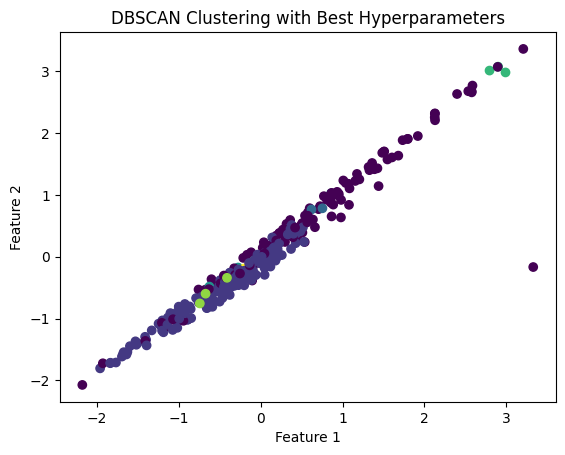

In [15]:
best_n_clusters = len(np.unique(best_clusters)) - 1
print(f"The best number of clusters is: {best_n_clusters}")

# Example: Print cluster assignments
print("Cluster Assignments:")
for label in np.unique(best_clusters):
    if label == -1:
        print(f"Noise points: {np.sum(best_clusters == label)}")
    else:
        print(f"Cluster {label}: {np.sum(best_clusters == label)} data points")

# Example: Visualize the clusters (you may use a suitable visualization library)
# This depends on the structure of your data and how you want to visualize it.
# For example, you can create a scatter plot using Matplotlib or Seaborn.
# Here's a basic example using Matplotlib:
import matplotlib.pyplot as plt
plt.scatter(pre_data[:, 0], pre_data[:, 1], c=best_clusters)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with Best Hyperparameters')
plt.show()

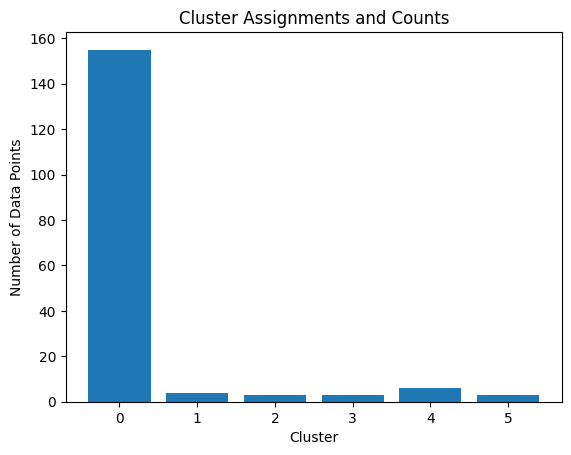

In [16]:
unique_clusters, cluster_counts = np.unique(best_clusters, return_counts=True)
unique_clusters = unique_clusters[1:]
cluster_counts = cluster_counts[1:]
plt.bar(unique_clusters, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Assignments and Counts')
plt.show()

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


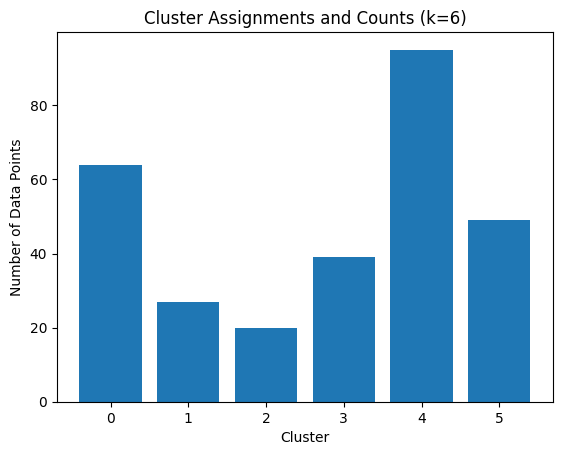

In [17]:
kmeans = KMeans(n_clusters=6,random_state=42,init="random",max_iter=100)
cluster_assignments = kmeans.fit_predict(pre_data)

# Count the number of data points in each cluster
unique_clusters, cluster_counts = np.unique(cluster_assignments, return_counts=True)

# Create a bar plot
plt.bar(unique_clusters, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title(f'Cluster Assignments and Counts (k={6})')
plt.show()

In [18]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
# Evaluate K-Means clustering using Silhouette Score and Davies-Bouldin Index
kmeans_silhouette = silhouette_score(pre_data, cluster_assignments)
kmeans_db_index = davies_bouldin_score(pre_data, cluster_assignments)

# Evaluate DBSCAN clustering using Silhouette Score and Davies-Bouldin Index
dbscan_silhouette = silhouette_score(pre_data, best_clusters)
dbscan_db_index = davies_bouldin_score(pre_data, best_clusters)


In [19]:
print(f'K-Means Silhouette Score: {kmeans_silhouette}')
print(f'K-Means Davies-Bouldin Index: {kmeans_db_index}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette}')
print(f'DBSCAN Davies-Bouldin Index: {dbscan_db_index}')

K-Means Silhouette Score: 0.26216517142908446
K-Means Davies-Bouldin Index: 1.1940803469250356
DBSCAN Silhouette Score: -0.1824823810415653
DBSCAN Davies-Bouldin Index: 1.7123449464688503


In [20]:
import joblib
with open("cluster_mode.pkl","wb") as f:
    joblib.dump(kmeans,f)

In [21]:
load_cluster = joblib.load("cluster_mode.pkl")

In [22]:
with open("cluster_mode.pkl", "rb") as f:
    cluster_assignments = joblib.load(f)

In [23]:
cluster_assignments = cluster_assignments.predict(pre_data)

In [24]:
cluster_assignments

array([2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 1, 5, 3, 4, 3, 3, 3,
       1, 3, 0, 0, 3, 3, 1, 1, 3, 1, 1, 5, 1, 5, 1, 1, 2, 2, 5, 1, 5, 0,
       0, 0, 0, 0, 3, 0, 3, 3, 5, 2, 5, 2, 1, 2, 5, 3, 1, 1, 3, 0, 0, 3,
       3, 3, 0, 0, 3, 5, 5, 2, 3, 1, 1, 2, 3, 5, 2, 2, 2, 1, 2, 1, 2, 1,
       1, 3, 3, 3, 3, 1, 1, 0, 3, 3, 0, 0, 0, 3, 3, 3, 3, 1, 2, 3, 0, 3,
       5, 5, 5, 2, 5, 4, 0, 5, 3, 1, 2, 5, 5, 5, 4, 4, 0, 0, 4, 5, 0, 0,
       4, 4, 4, 5, 5, 5, 5, 4, 4, 4, 2, 5, 4, 4, 4, 4, 4, 5, 5, 4, 5, 4,
       4, 4, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 5, 5, 2, 5, 2, 4, 0, 4, 4, 5,
       5, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 4, 0, 4, 4,
       4, 0, 0, 3, 0, 4, 5, 4, 4, 0, 4, 0, 4, 3, 1, 5, 4, 4, 0, 0, 3, 4,
       4, 4, 3, 3, 4, 4, 0, 0, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 5, 4, 5, 5, 4, 4, 4, 0,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 5, 4, 5, 5, 5,
       1, 4, 4, 4, 5, 1, 5, 1])

In [25]:
label = {"good","fair","moderator","poor","very poor","Extremely poor"}
zipping = dict(zip(np.unique(kmeans.labels_),label))

In [26]:
import json
data_to_write = {str(key): value for key, value in zipping.items()}
with open("label_cluster.json","w") as f:
    json.dump(data_to_write,f)


In [27]:
with open('label_cluster.json', 'r') as file:
    # Load JSON data from the file
    label = json.load(file)

# Time Series Data preprocessing

In [28]:
times_series_df = data.set_index("time")
times_series_df = times_series_df.resample("D").mean().round(3)
times_series_df.reset_index(inplace=True)

In [29]:
times_series_df.head()

,time,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
0,2023-01-01,31.179,21.467,554.750,9.929,61.458,0.387,0.000
1,2023-01-02,20.875,14.025,365.792,5.804,59.625,0.242,0.500
2,2023-01-03,12.717,8.242,226.167,5.238,30.375,0.160,0.333
3,2023-01-04,9.517,6.112,169.750,3.404,30.542,0.157,0.000
4,2023-01-05,7.117,4.492,157.417,2.138,39.958,0.103,0.000


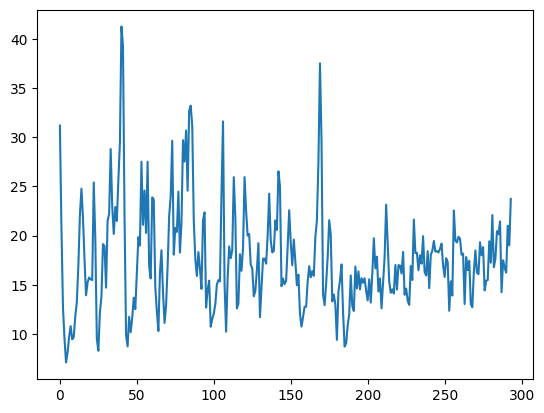

In [30]:
plt.plot(times_series_df["pm10"])

In [31]:
# check outlier
features = times_series_df.select_dtypes(include=np.number).columns
for feat in features:
    outliers = detect_outlier_zscore(times_series_df[feat])
    print(f"Outliers in {feat} are at indices: {outliers[0]}")

Outliers in pm10 are at indices: [ 40  41 169]
Outliers in pm2_5 are at indices: [ 40  41  85 169]
Outliers in carbon_monoxide are at indices: [33 40 86]
Outliers in nitrogen_dioxide are at indices: [22 33 40 61 86]
Outliers in ozone are at indices: [169]
Outliers in aerosol_optical_depth are at indices: [41 85]
Outliers in dust are at indices: [ 12  13  49  50  75 135]


In [32]:
# setting `time` feature be index
times_series_df.set_index("time",inplace=True)
times_series_df.head()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
time,,,,,,,
2023-01-01,31.179,21.467,554.750,9.929,61.458,0.387,0.000
2023-01-02,20.875,14.025,365.792,5.804,59.625,0.242,0.500
2023-01-03,12.717,8.242,226.167,5.238,30.375,0.160,0.333
2023-01-04,9.517,6.112,169.750,3.404,30.542,0.157,0.000
2023-01-05,7.117,4.492,157.417,2.138,39.958,0.103,0.000


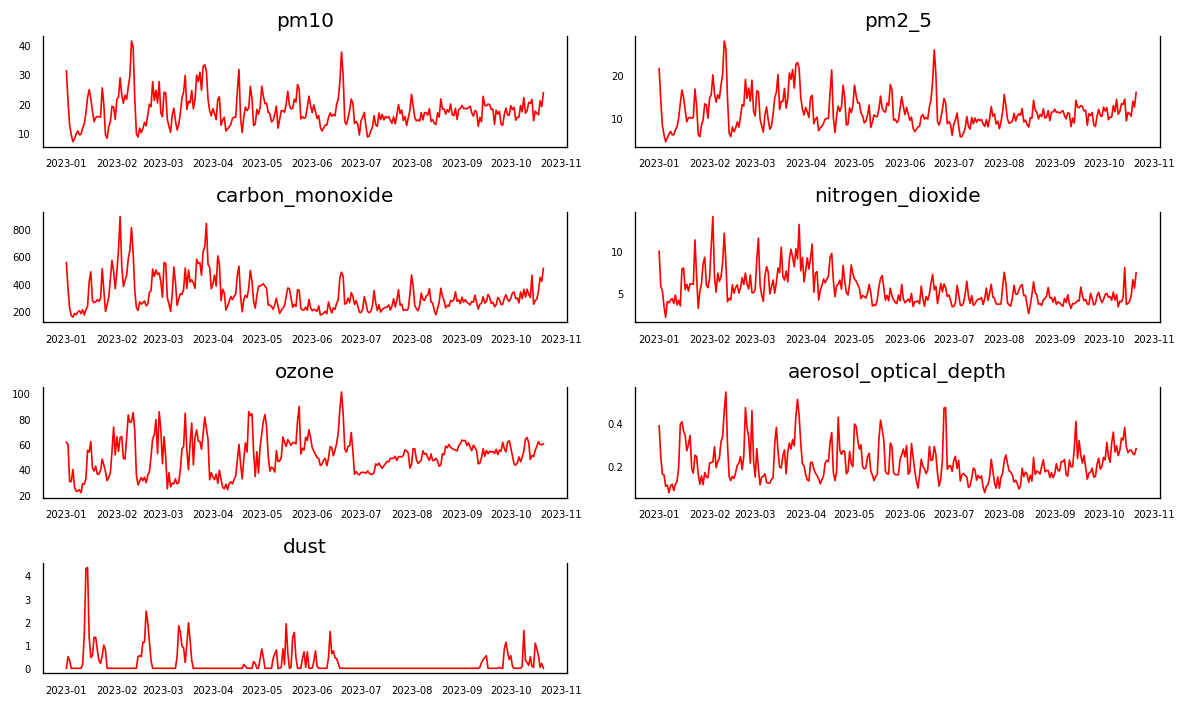

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    if i < len(times_series_df.columns):
        data = times_series_df[times_series_df.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(times_series_df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    else:
        # Jika ada subplot yang tersisa, hilangkan sumbunya.
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [34]:
grangers_causation_matrix(data=times_series_df, variables = times_series_df.columns)

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  

,pm10_x,pm2_5_x,carbon_monoxide_x,nitrogen_dioxide_x,ozone_x,aerosol_optical_depth_x,dust_x
pm10_y,0.0000,0.3259,0.2021,0.0952,0.0269,0.0304,0.0360
pm2_5_y,0.1837,0.0000,0.1482,0.0714,0.0447,0.0362,0.0285
carbon_monoxide_y,0.0132,0.0118,0.0000,0.0001,0.0016,0.0252,0.1546
nitrogen_dioxide_y,0.0162,0.0097,0.0033,0.0000,0.1185,0.0055,0.0897
ozone_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0202,0.0104
aerosol_optical_depth_y,0.0394,0.0264,0.0242,0.0155,0.3937,0.0000,0.0004
dust_y,0.0201,0.0264,0.1120,0.5527,0.0155,0.0395,0.0000


In [38]:
# Mengecek dan menghapus kolom dengan nilai konstan
constant_columns = times_series_df.columns[times_series_df.nunique() == 1]
times_series_df = times_series_df.drop(columns=constant_columns)
result = grangers_causation_matrix(times_series_df,variables=times_series_df.columns)
result

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  

,pm10_x,pm2_5_x,carbon_monoxide_x,nitrogen_dioxide_x,ozone_x,aerosol_optical_depth_x,dust_x
pm10_y,0.0000,0.3259,0.2021,0.0952,0.0269,0.0304,0.0360
pm2_5_y,0.1837,0.0000,0.1482,0.0714,0.0447,0.0362,0.0285
carbon_monoxide_y,0.0132,0.0118,0.0000,0.0001,0.0016,0.0252,0.1546
nitrogen_dioxide_y,0.0162,0.0097,0.0033,0.0000,0.1185,0.0055,0.0897
ozone_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0202,0.0104
aerosol_optical_depth_y,0.0394,0.0264,0.0242,0.0155,0.3937,0.0000,0.0004
dust_y,0.0201,0.0264,0.1120,0.5527,0.0155,0.0395,0.0000


# Reference

![VAR Forecasting](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/#google_vignette)

![Aritma Forecasting](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#google_vignette)